In [1]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import cv2
import random

2025-03-04 16:48:49.941282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 16:48:49.955998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 16:48:49.960146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 16:48:49.973244: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Definir nível de log para erro (ignora warnings e info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

In [3]:
def calculate_label(image, threshold=0.01):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(data_right)
                patient_data["mask_right"].append(data_msk_right)
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [4]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

def criar_imagem_vermelha(imagem):
    shape = imagem.shape  # Obtém o shape da imagem original
    vermelho = np.zeros((*shape, 3), dtype=np.uint8)  # Criar imagem RGB vazia
    vermelho[:, :, 0] = 255  # Define apenas o canal vermelho como máximo (255)
    return vermelho

def criar_imagem_preta(imagem_original):
    return np.zeros_like(imagem_original)  # Cria uma imagem preta do mesmo tamanho

In [ ]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    
    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        class_1_coordinates = {}
        class_0_coordinates = {}
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0

        train_patients = ['sub-00H10', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16I12', 'sub-19G04', 'sub-22F14', 'sub-25B08', 'sub-26B09', 'sub-34J06', 'sub-35E12', 'sub-36K02', 'sub-42K06', 'sub-03C08', 'sub-51C05', 'sub-52K04', 'sub-56E13', 'sub-59E09''sub-41D08', 'sub-57D04', 'sub-59G00', 'sub-60G06', 'sub-72K02', 'sub-76J09', 'sub-79H07', 'sub-83K08', 'sub-85I05', 'sub-86B13', 'sub-86G08']
        valid_patients = ['sub-02A13', 'sub-16G09', 'sub-29D03', 'sub-31F07', 'sub-19F09', 'sub-42B05', 'sub-44H05', 'sub-76E02']
        test_patients = ['sub-03C08', 'sub-51C05', 'sub-52K04', 'sub-59E09']

        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels\n",
        if len(labels_pair[patient_id]) == 0:
            continue
        
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count and  patient_id not in test_patients:
            sampled_indices = np.random.choice(len(class_0_left[patient_id]), class_1_count, replace=False)
            #sampled_indices = [i for i in range(class_1_count)]

            sampled_class_0_slices_left = []
            sampled_class_0_slices_right = []
            sampled_class_0_mask_left = []
            sampled_class_0_mask_right = []

            #print(sampled_indices)

            for i in range(len(class_0_left[patient_id])):
                if i in sampled_indices:
                    sampled_class_0_slices_left.append([class_0_left[patient_id][i]])
                    sampled_class_0_slices_right.append([class_0_right[patient_id][i]])
                    sampled_class_0_mask_left.append([class_0_mask_left[patient_id][i]])
                    sampled_class_0_mask_right.append([class_0_mask_right[patient_id][i]])
                else:
                    sampled_class_0_slices_left.append([criar_imagem_preta(class_0_left[patient_id][i])])
                    sampled_class_0_slices_right.append([criar_imagem_preta(class_0_right[patient_id][i])])
                    sampled_class_0_mask_left.append([criar_imagem_preta(class_0_mask_left[patient_id][i])])
                    sampled_class_0_mask_right.append([criar_imagem_preta(class_0_mask_right[patient_id][i])])

            print(f"tamanho slices left: {len(sampled_class_0_slices_left)}")
            print(f"tamanho slices right: {len(sampled_class_0_slices_right)}")
            print(f"tamanho mask left: {len(sampled_class_0_mask_left)}")
            print(f"tamanho mask right: {len(sampled_class_0_mask_right)}")
            
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []

            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * len(class_0_mask_original_modified[patient_id])

        if patient_id in test_patients:
            class_0_original_modified = class_0_left
            class_0_opposite_modified = class_0_right
            class_0_mask_original_modified = class_0_mask_left
            class_0_mask_opposite_modified = class_0_mask_right

        balanced_images_left[patient_id] = list(class_1_left[patient_id]) + list(class_0_original_modified[patient_id])
        balanced_images_right[patient_id] = list(class_1_right[patient_id]) + list(class_0_opposite_modified[patient_id])
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_left[patient_id] = list(class_1_mask_left[patient_id]) + list(class_0_mask_original_modified[patient_id])
        balanced_mask_right[patient_id] = list(class_1_mask_right[patient_id]) + list(class_0_mask_opposite_modified[patient_id])

        print(f"Paciente {patient_id}:")

        print(f"  Tamanho de class_1_left[{patient_id}]: {len(class_1_left[patient_id])}")
        print(f"  Tamanho de class_0_original_modified[{patient_id}]: {len(class_0_original_modified[patient_id])}")
        print(f"  Tamanho de balanced_images_left[{patient_id}]: {len(balanced_images_left[patient_id])}")

        print(f"  Tamanho de class_1_right[{patient_id}]: {len(class_1_right[patient_id])}")
        print(f"  Tamanho de class_0_opposite_modified[{patient_id}]: {len(class_0_opposite_modified[patient_id])}")
        print(f"  Tamanho de balanced_images_right[{patient_id}]: {len(balanced_images_right[patient_id])}")

        print(f"  Tamanho de class_1_labels: {len(class_1_labels)}")
        print(f"  Tamanho de class_0_labels: {len(class_0_labels)}")
        print(f"  Tamanho de balanced_labels[{patient_id}]: {len(balanced_labels[patient_id])}")

        print(f"  Tamanho de class_1_mask_left[{patient_id}]: {len(class_1_mask_left[patient_id])}")
        print(f"  Tamanho de class_0_mask_original_modified[{patient_id}]: {len(class_0_mask_original_modified[patient_id])}")
        print(f"  Tamanho de balanced_mask_left[{patient_id}]: {len(balanced_mask_left[patient_id])}")

        print(f"  Tamanho de class_1_mask_right[{patient_id}]: {len(class_1_mask_right[patient_id])}")
        print(f"  Tamanho de class_0_mask_opposite_modified[{patient_id}]: {len(class_0_mask_opposite_modified[patient_id])}")
        print(f"  Tamanho de balanced_mask_right[{patient_id}]: {len(balanced_mask_right[patient_id])}")

        print("=" * 80)  # Separador para facilitar a leitura

        print(f"Paciente {patient_id}:")    
        print(f"Tamanho de balanced_labels: {len(balanced_labels[patient_id])}")
        print(f"Tamanho de balanced_images_left: {len(balanced_images_left[patient_id])}")
        print(f"Tamanho de balanced_images_right: {len(balanced_images_right[patient_id])}")
        print(f"Tamanho de balanced_mask_left: {len(balanced_mask_left[patient_id])}")
        print(f"Tamanho de balanced_mask_right: {len(balanced_mask_right[patient_id])}")
        
        #balanced_index = np.random.choice(range(len(balanced_labels[patient_id])), len(balanced_labels[patient_id]), replace=False)            
        
        # DEPOIS DE TUDO FEITO, ESSE AQUI MANTÉM A ORDEM DAS FATIAS
        balanced_index = [i for i in range(len(balanced_labels[patient_id]))]          
        
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels[patient_id] = [balanced_labels[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
        
    # Separar os dados por conjunto (treino, validação, teste)
    #patients = list(set(balanced_labels.keys()))
    #train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    #valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size)

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_left, balanced_images_right, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), train_patients, valid_patients, test_patients, balanced_index

In [6]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def salvar_pares_imagens_pdf(left_images, right_images, pdf_filename):
    """
    Salva pares de imagens em um PDF, com 4 pares (8 imagens) por página.

    Parâmetros:
    - left_images: Lista ou array com as imagens do lado esquerdo.
    - right_images: Lista ou array com as imagens do lado direito.
    - pdf_filename: Nome do arquivo PDF de saída.

    """
    with PdfPages(pdf_filename) as pdf:
        image_pairs = list(zip(left_images, right_images))
        
        for i in range(0, len(image_pairs), 4):  # Processando 4 pares por página
            fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Criando grade 4x2
            
            for j in range(4):  # Adicionando 4 pares por página
                if i + j < len(image_pairs):  # Verifica se ainda há imagens disponíveis
                    l_image, r_image = image_pairs[i + j]
                    
                    # Primeira coluna (Recorte Esquerda)
                    axes[j, 0].imshow(l_image, cmap='gray')
                    axes[j, 0].axis('off')
                    axes[j, 0].set_title(f"Recorte Esquerda {i+j+1}")
                    
                    # Segunda coluna (Recorte Direita)
                    axes[j, 1].imshow(r_image, cmap='gray')
                    axes[j, 1].axis('off')
                    axes[j, 1].set_title(f"Recorte Direita {i+j+1}")

            # Ajustar layout e salvar no PDF
            plt.tight_layout()
            pdf.savefig(fig)  
            plt.close(fig)

    print(f"PDF salvo como {pdf_filename}")

In [7]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
patient_ids = [os.listdir(folder)[i] for i in range(0, 1)]
#patient = os.listdir(folder)[0]

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# AJUSTE PRA TER NO DICIONÁRIO CADA NÍVEL DE UM PACIENTE

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1026


In [8]:
print(patient_ids)
print(len(X_left['sub-00H10']))
print(len(X_right['sub-00H10']))
print(len(mask_left['sub-00H10']))
print(len(mask_right['sub-00H10']))
print(len(y['sub-00H10']))
print(y['sub-00H10'].count(0))
print(y['sub-00H10'].count(1))

['sub-00H10']
1026
1026
1026
1026
1026
966
60


In [9]:
test_imgs, test_label = load_patient_data(folder, os.listdir(folder)[0])

test_left, test_right = test_imgs['images_left'], test_imgs['images_right']

test_left = normalize_minmax(np.array([elemento for elemento in test_left]))
test_left = np.expand_dims(test_left, axis=-1)
test_right = normalize_minmax(np.array([elemento for elemento in test_right]))
test_right= np.expand_dims(test_right, axis=-1)

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1026


In [35]:
# Nome do arquivo PDF
os.makedirs("Pdf", exist_ok=True)
pdf_filename = "Pdf/imagens_recortes_pre_undersampling.pdf"

salvar_pares_imagens_pdf(X_left['sub-00H10'], X_right['sub-00H10'], pdf_filename)

PDF salvo como Pdf/imagens_recortes_pre_undersampling.pdf


In [13]:
# Preparar dados para treino e validação
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients, index_vec = prepare_data_for_training(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)        

Paciente sub-00H10: Total de pares de recortes com labels 1: 60
tamanho slices left: 966
tamanho slices right: 966
tamanho mask left: 966
tamanho mask right: 966
Paciente sub-00H10:
  Tamanho de class_1_left[sub-00H10]: 60
  Tamanho de class_0_original_modified[sub-00H10]: 966
  Tamanho de balanced_images_left[sub-00H10]: 1026
  Tamanho de class_1_right[sub-00H10]: 60
  Tamanho de class_0_opposite_modified[sub-00H10]: 966
  Tamanho de balanced_images_right[sub-00H10]: 1026
  Tamanho de class_1_labels: 60
  Tamanho de class_0_labels: 966
  Tamanho de balanced_labels[sub-00H10]: 1026
  Tamanho de class_1_mask_left[sub-00H10]: 60
  Tamanho de class_0_mask_original_modified[sub-00H10]: 966
  Tamanho de balanced_mask_left[sub-00H10]: 1026
  Tamanho de class_1_mask_right[sub-00H10]: 60
  Tamanho de class_0_mask_opposite_modified[sub-00H10]: 966
  Tamanho de balanced_mask_right[sub-00H10]: 1026
Paciente sub-00H10:
Tamanho de balanced_labels: 1026
Tamanho de balanced_images_left: 1026
Tamanho 

Ocorrências de shape (40, 40): 60
Ocorrências de shape (40,): 0
1026
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


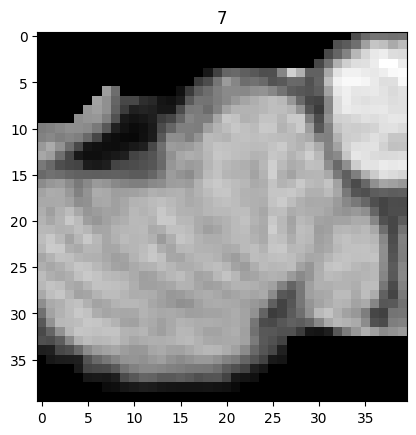

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


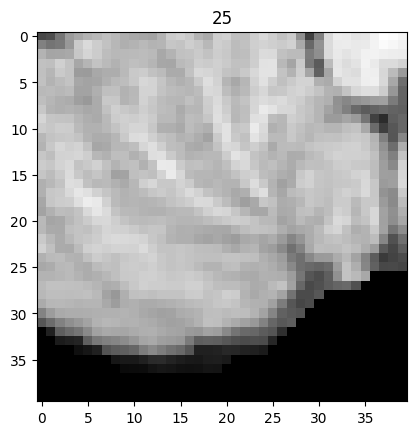

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


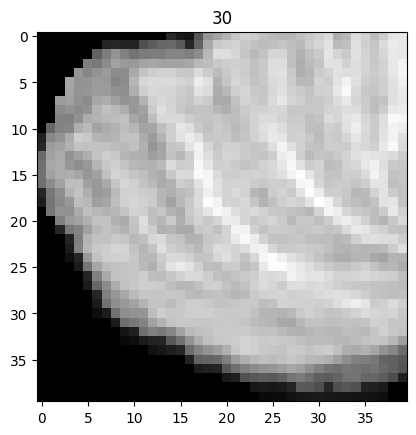

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


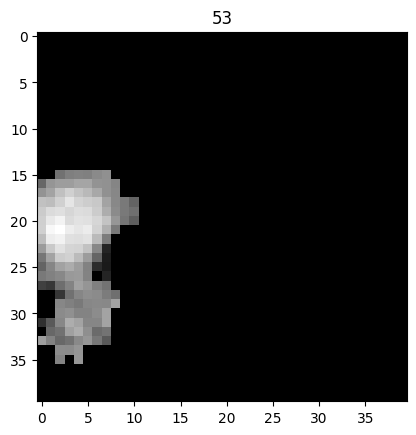

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


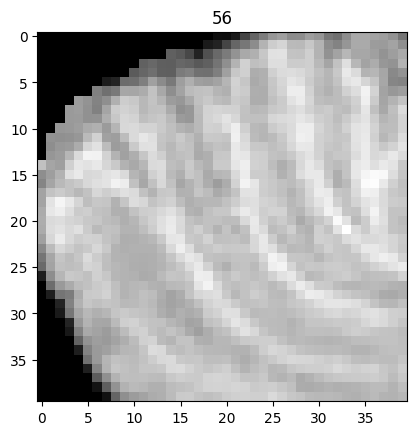

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


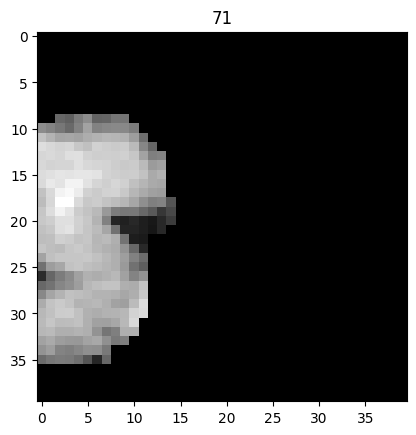

(40, 40)


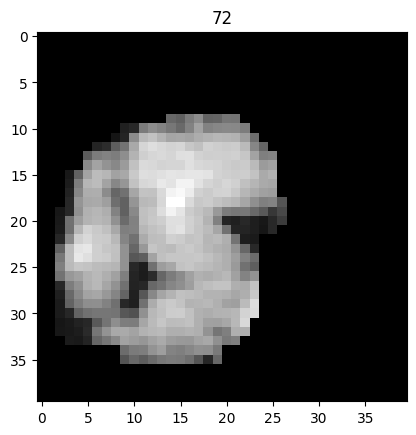

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


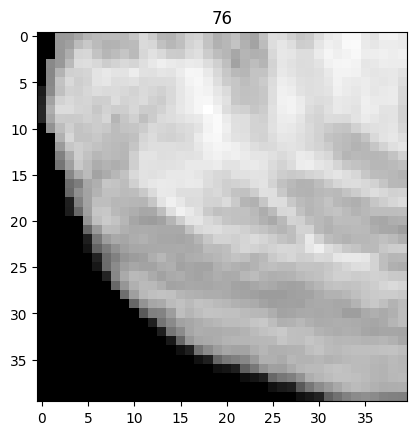

(40, 40)
imagem retirada
(40, 40)


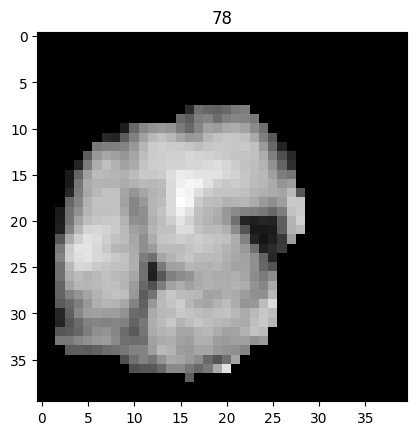

(40, 40)


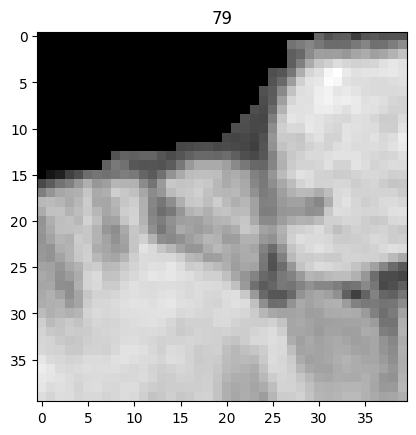

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


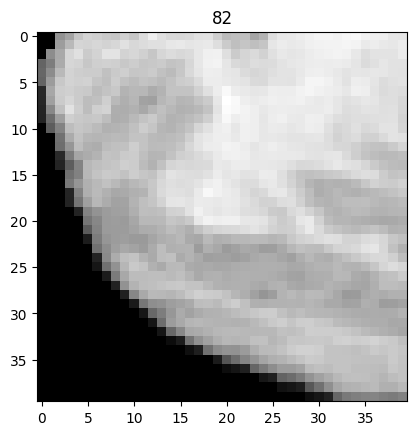

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


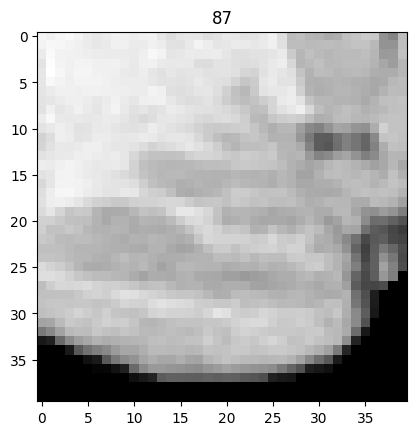

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


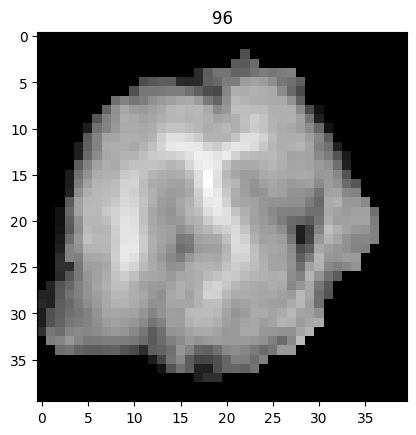

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


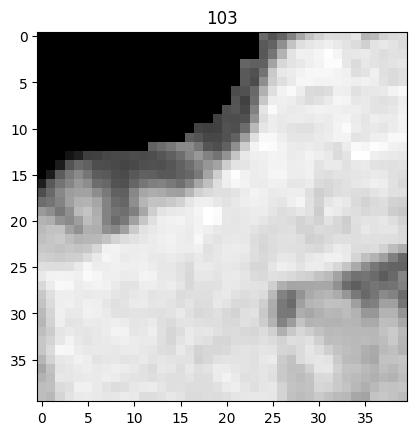

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


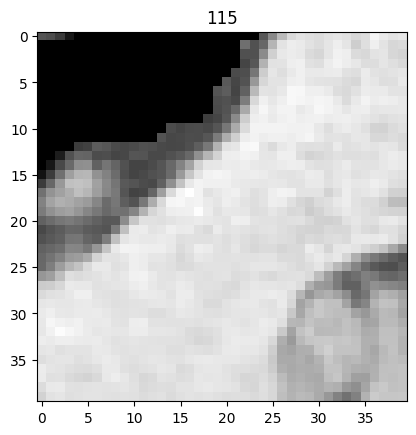

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


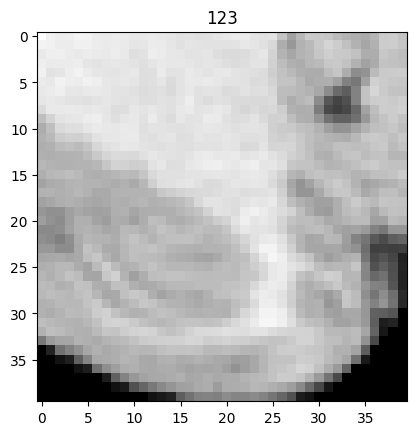

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada


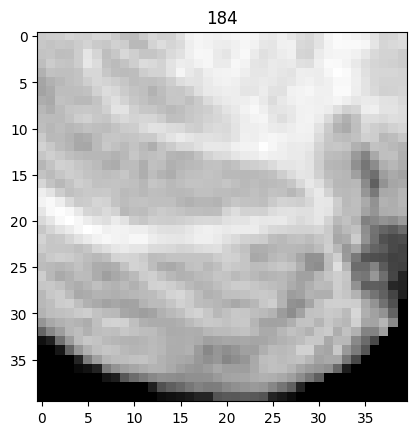

(40, 40)
imagem retirada
(40, 40)


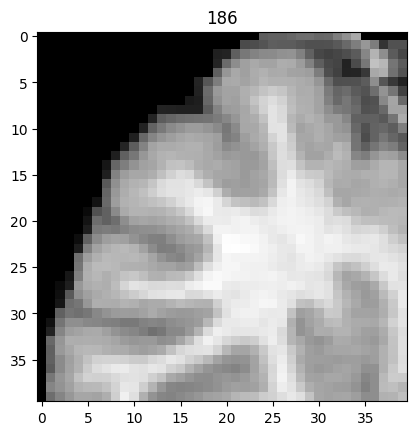

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


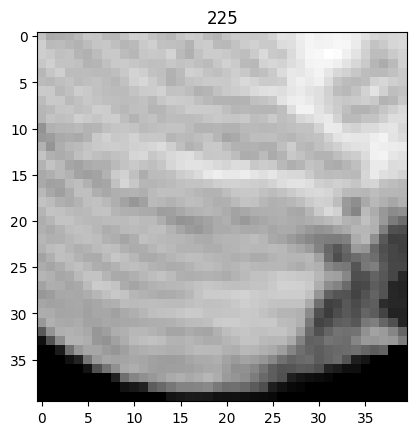

(40, 40)
imagem retirada
(40, 40)


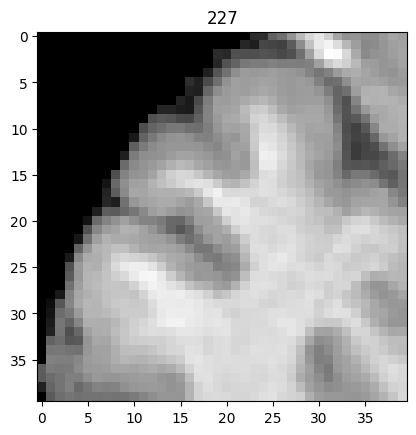

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


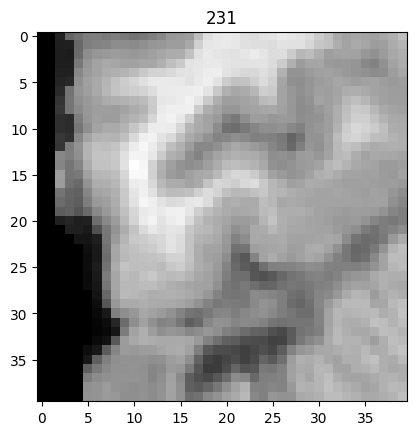

(40, 40)
imagem retirada
(40, 40)


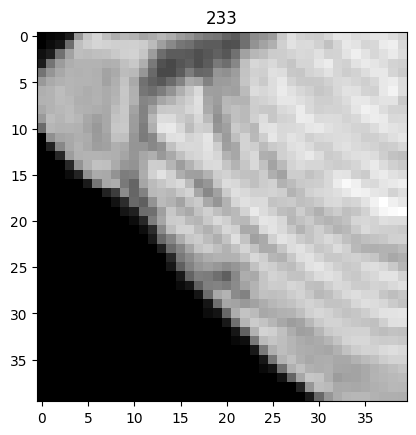

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


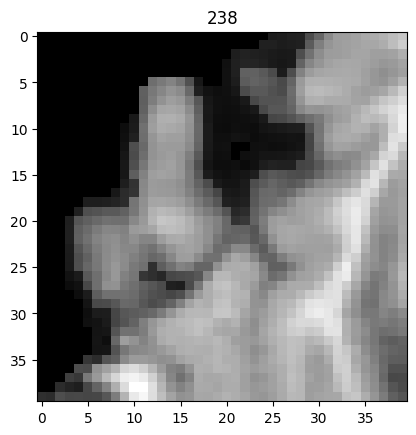

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


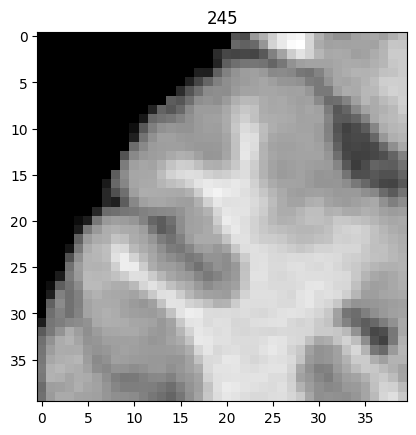

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


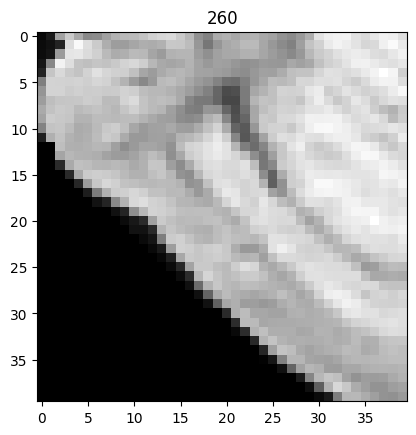

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada


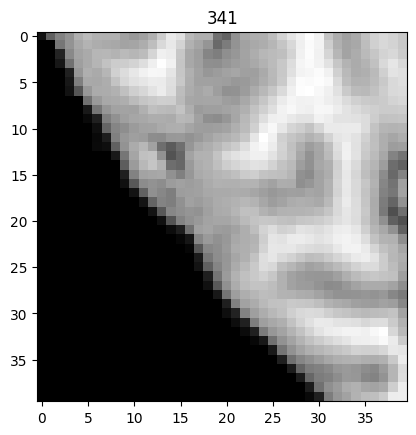

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


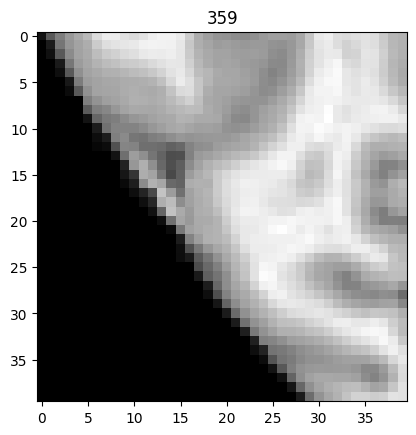

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


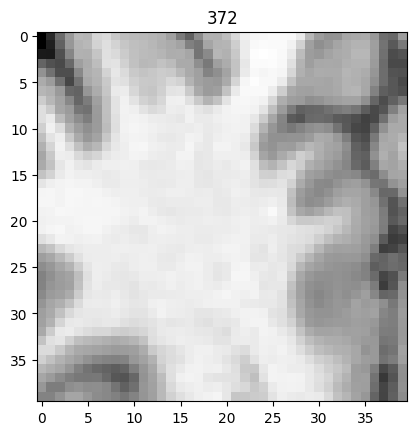

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


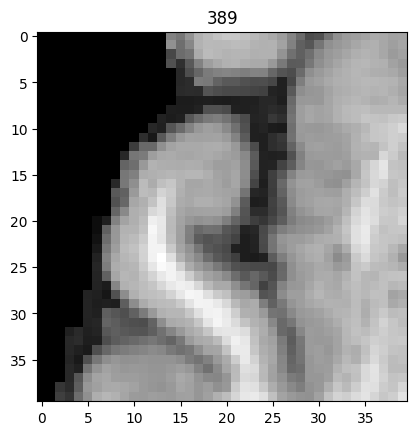

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


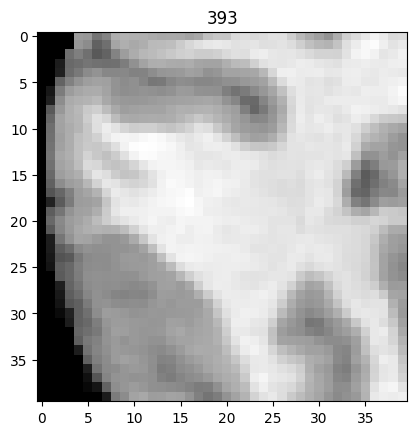

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


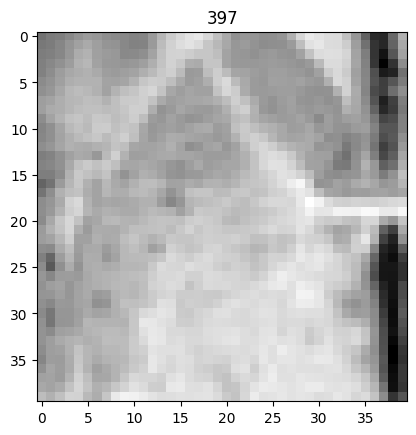

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


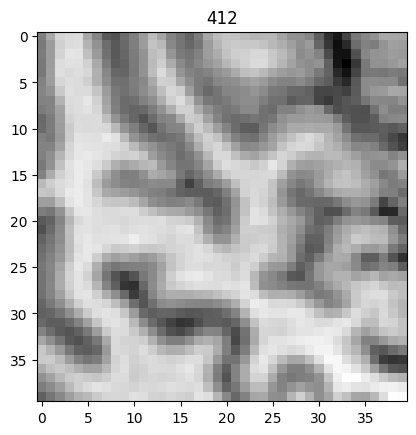

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


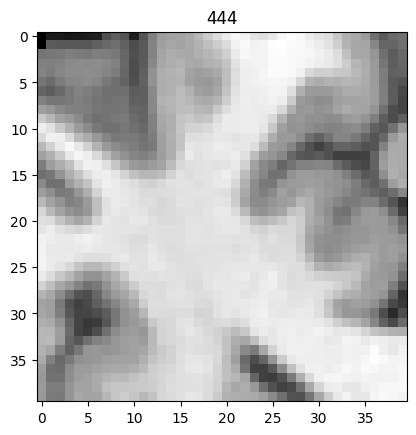

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


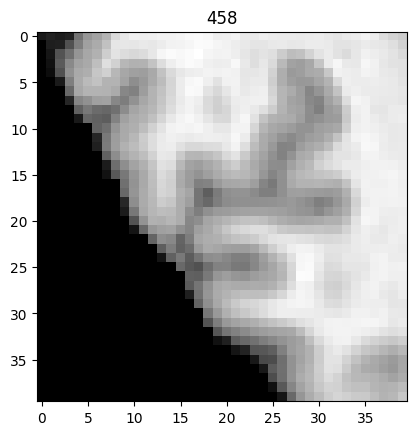

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


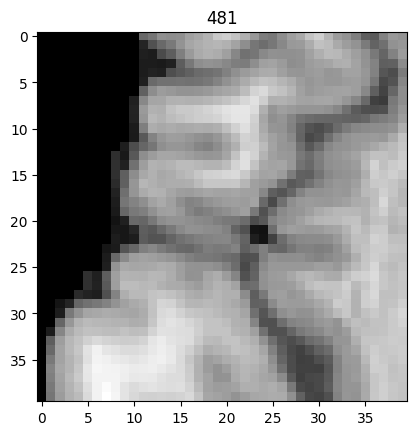

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


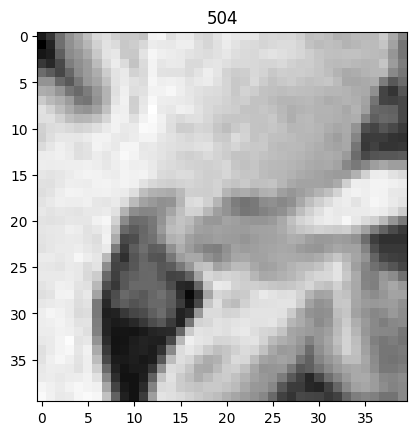

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


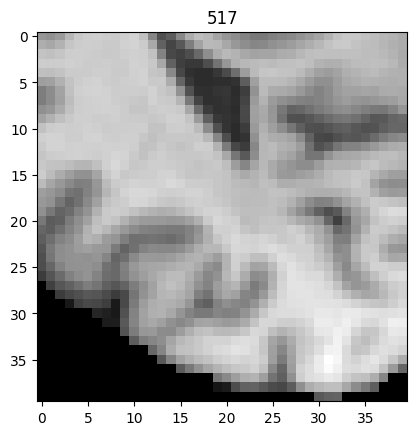

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada


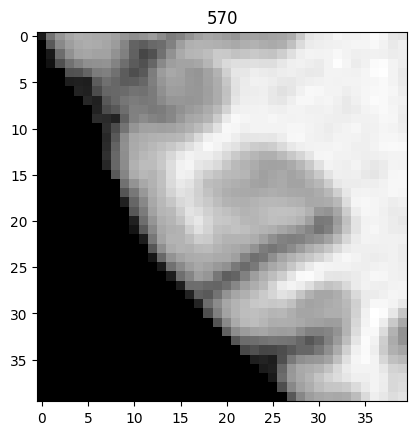

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


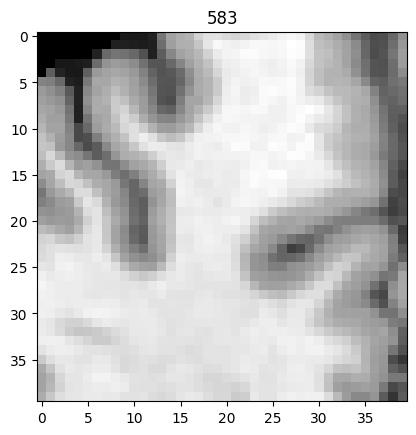

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


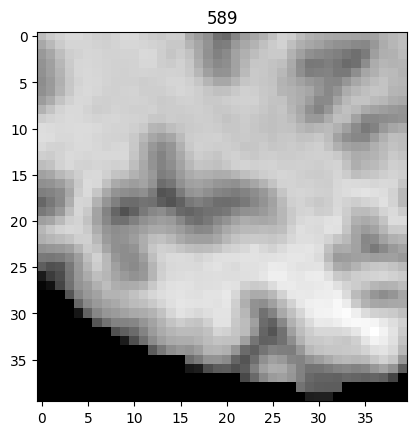

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


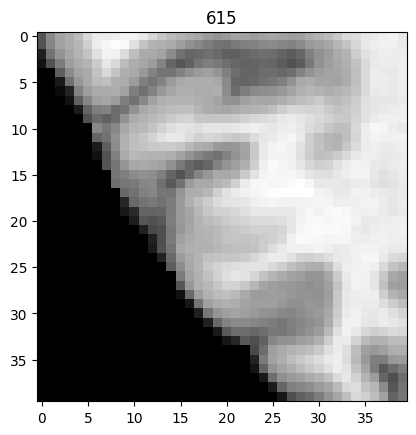

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


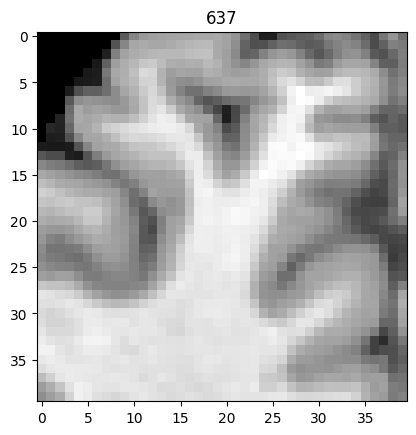

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada


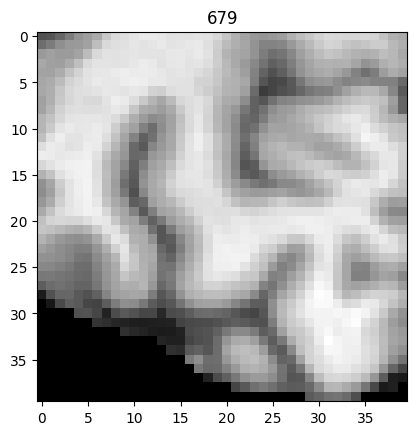

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


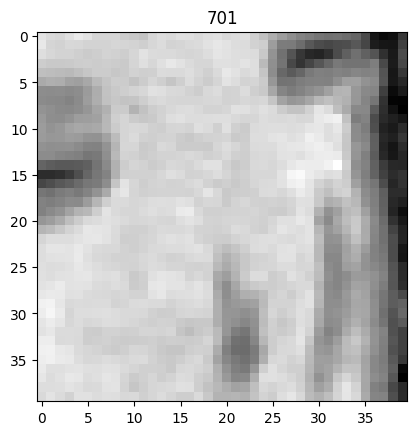

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


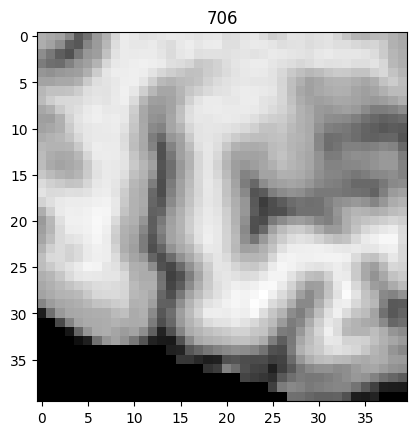

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


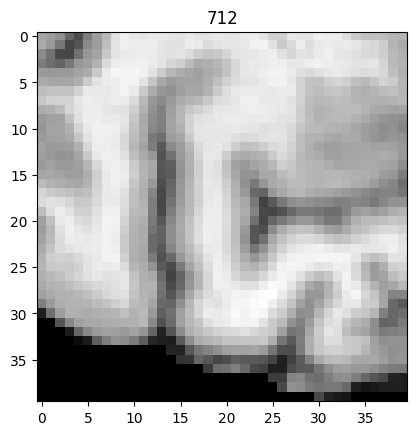

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


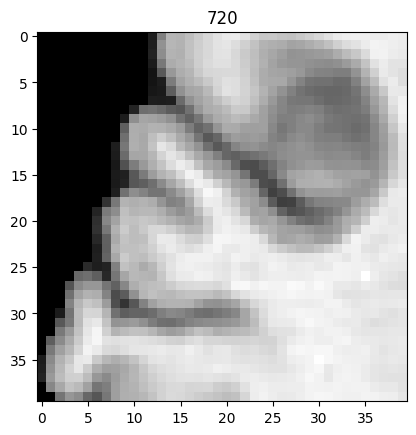

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


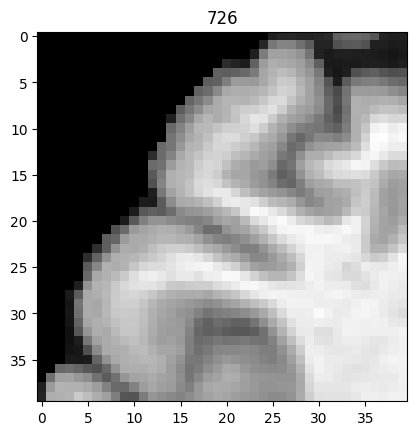

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


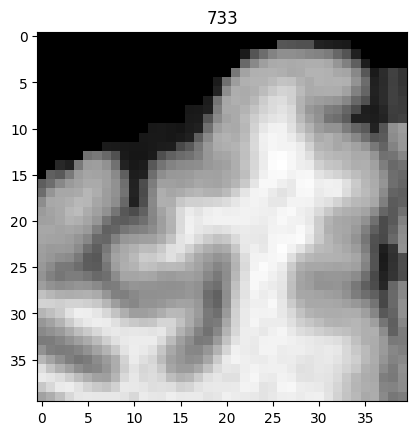

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


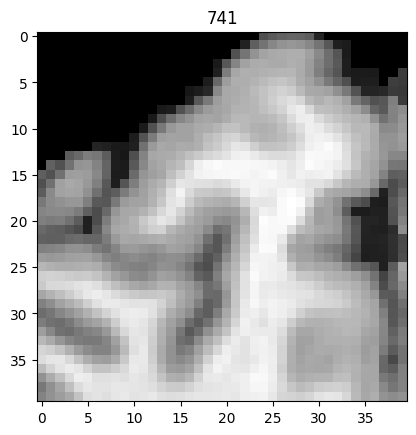

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


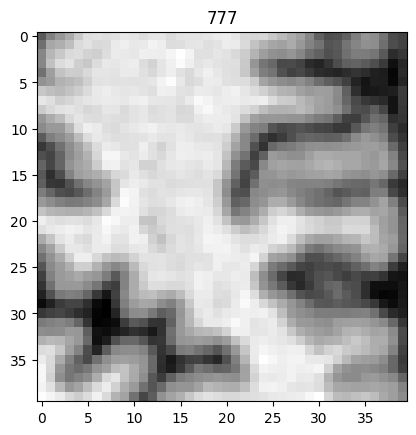

(40, 40)


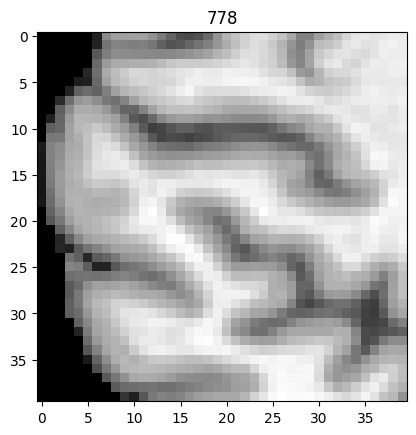

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


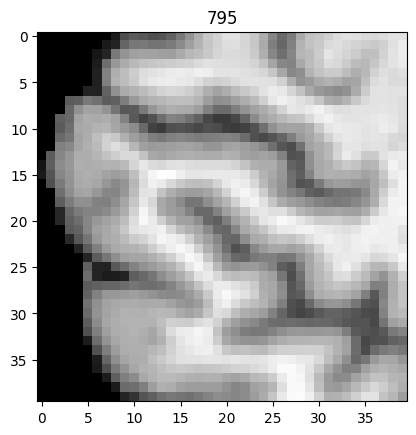

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


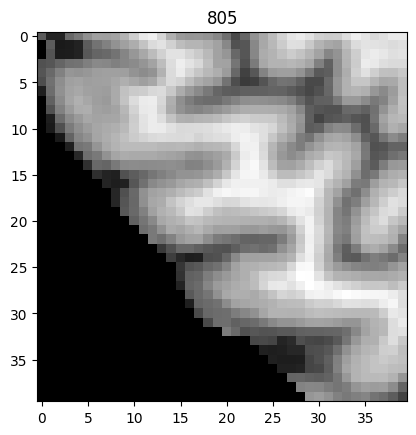

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


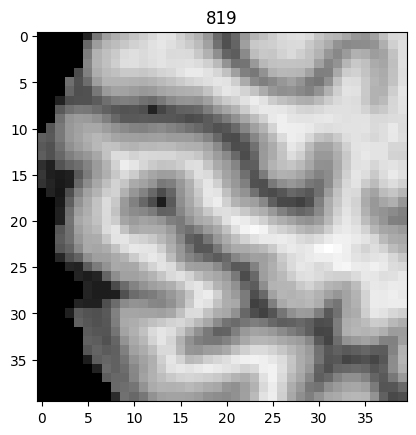

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


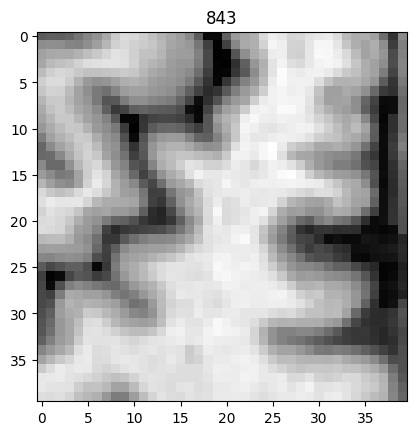

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada


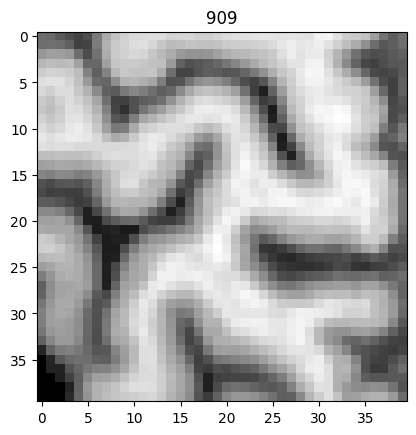

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


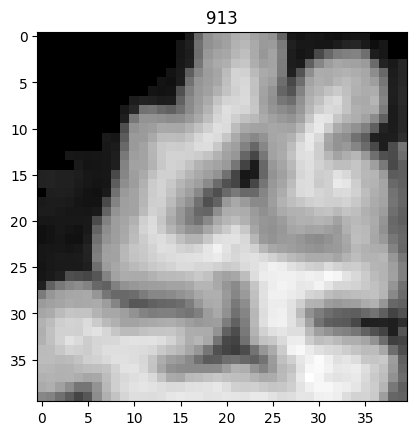

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)


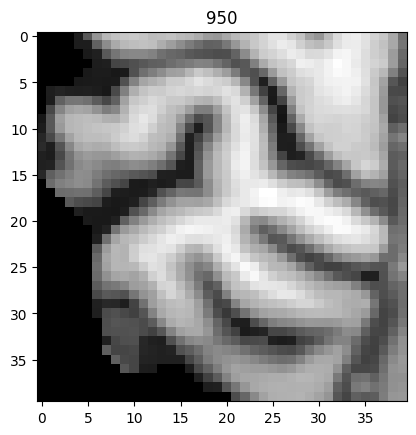

(40, 40)


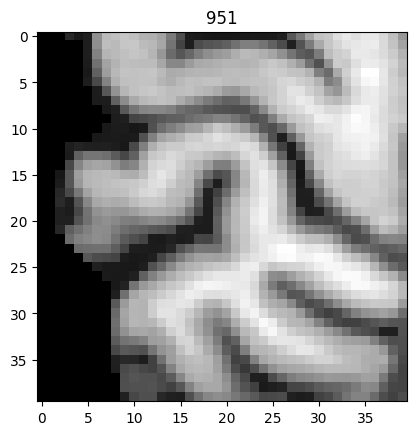

(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
(40, 40)
imagem retirada
966


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1026,) + inhomogeneous part.

In [14]:
# Lista de arrays (extraída do dicionário train_left_balanced)
testing = [elemento for lista in train_left_balanced.values() for elemento in lista]

# Contadores
contagem_40_40 = sum(1 for item in testing if isinstance(item, np.ndarray) and item.shape == (40, 40))
contagem_40 = sum(1 for item in testing if isinstance(item, np.ndarray) and item.shape == (40,))

print(f"Ocorrências de shape (40, 40): {contagem_40_40}")
print(f"Ocorrências de shape (40,): {contagem_40}")

print(len(testing))

cont = 0

for item in testing:
    if item[0].ndim == 2:
        print(item[0].shape)
        if np.count_nonzero(item[0]) > 0:
            plt.imshow(item[0], cmap='gray')
            plt.title(cont)
            plt.show()
        else:
            print("imagem retirada")
        cont += 1

print(cont)


# Adiciono camada de cor
train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)

In [15]:
#train_left_balanced, train_right_balanced, train_patients

print(len(train_left_balanced))
print(len(train_right_balanced))
print(len(valid_left_balanced))
print(len(valid_left_balanced))
print(len(test_left))
print(len(test_right))
print(len(y_train_balanced))

28
28
8
8
4
4
1026


/tmp/ipykernel_951/222368210.py:14: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  with PdfPages(pdf_filename) as pdf:


TypeError: Image data of dtype <U9 cannot be converted to float

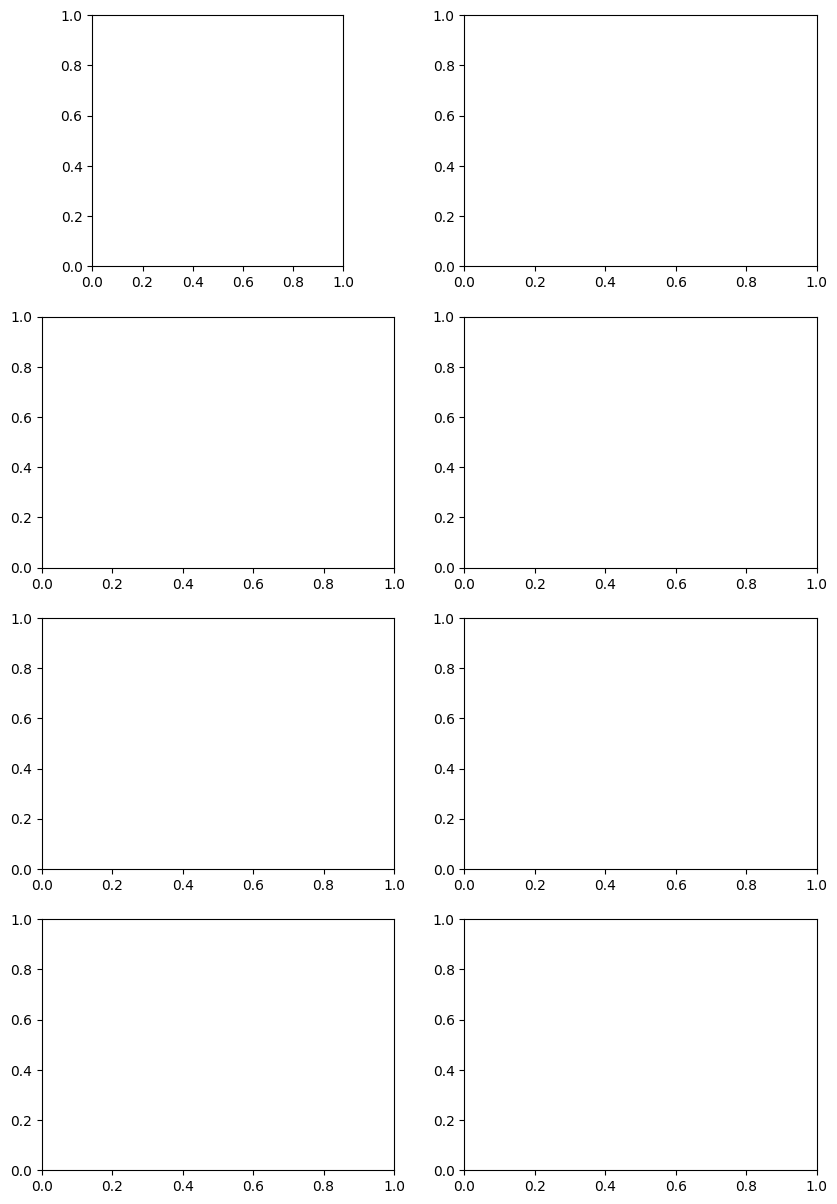

In [36]:
# Nome do arquivo PDF
os.makedirs("Pdf", exist_ok=True)
pdf_filename = "Pdf/imagens_recortes_pos_undersampling.pdf"

salvar_pares_imagens_pdf(train_left_balanced, train_right_balanced, pdf_filename)

In [40]:
print(len(test_right))
print(len(test_left))
print(len(labels_pair))

1026
1026
1026


In [23]:
for i in range(0, len(train_left_balanced['sub-00H10'])):
    print(i, train_left_balanced['sub-00H10'][i].ndim)

0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 2
43 2
44 2
45 2
46 2
47 2
48 2
49 2
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2


AttributeError: 'list' object has no attribute 'ndim'

(40, 40)
(40, 40)


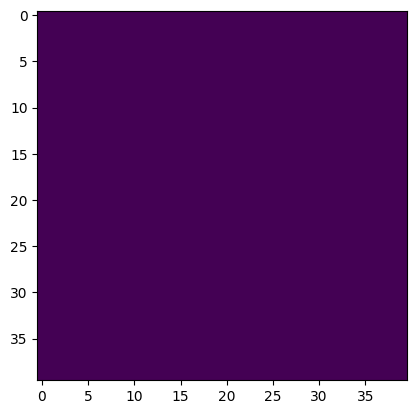

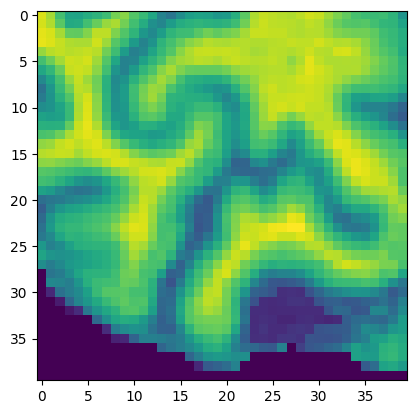

In [34]:
print(train_left_balanced['sub-00H10'][60][0].shape)
print(train_left_balanced['sub-00H10'][59].shape)

plt.imshow(train_left_balanced['sub-00H10'][60][0])
plt.show()
plt.imshow(train_left_balanced['sub-00H10'][59])
plt.show()

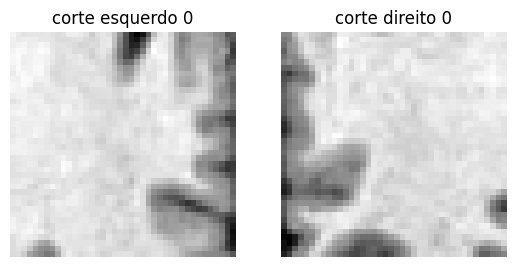

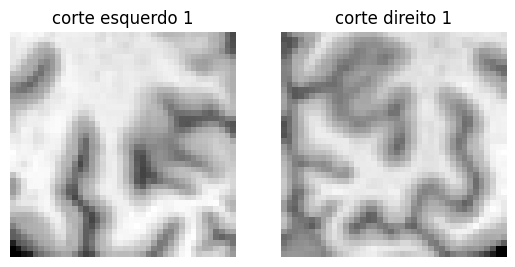

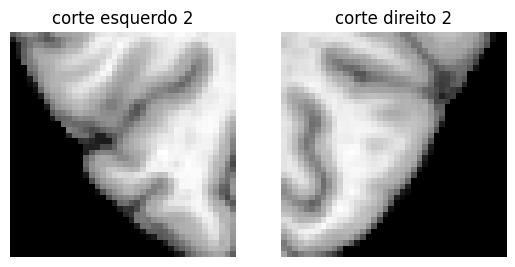

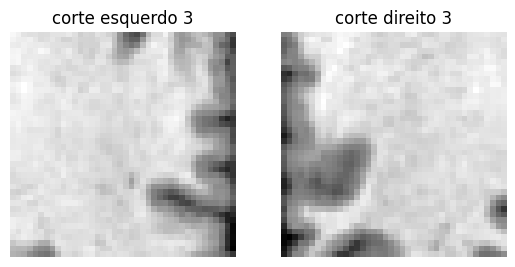

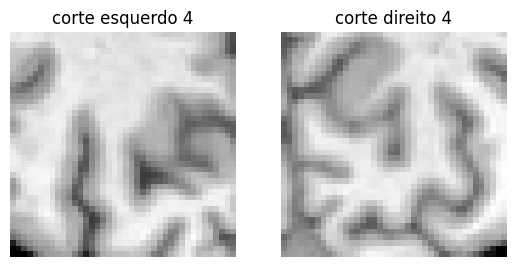

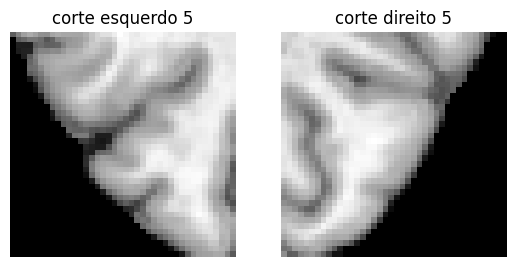

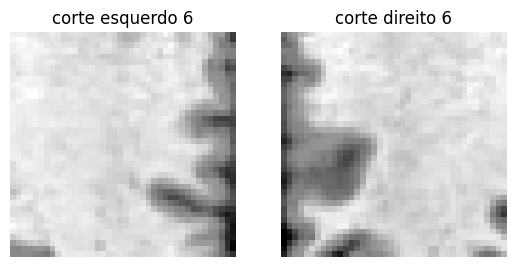

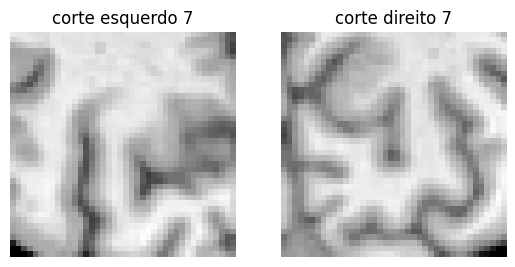

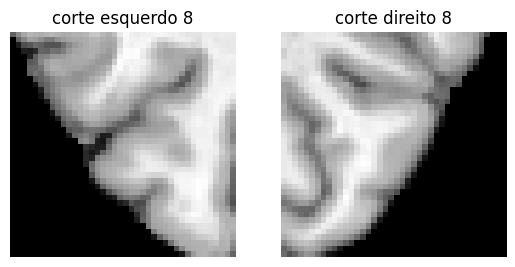

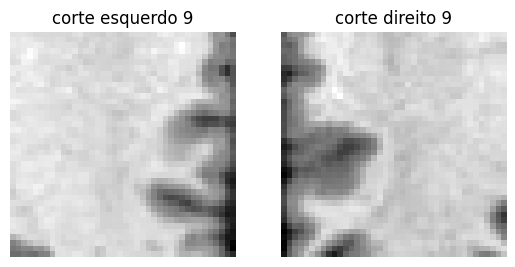

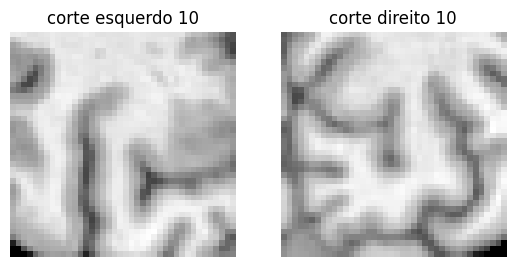

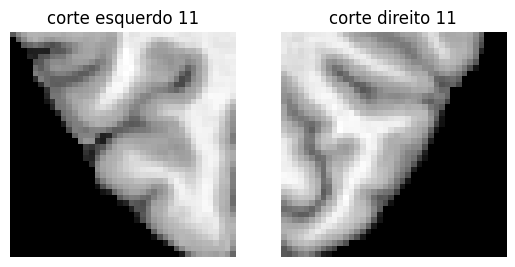

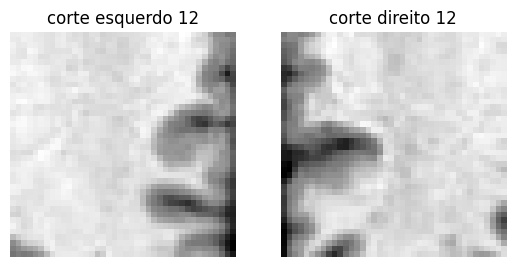

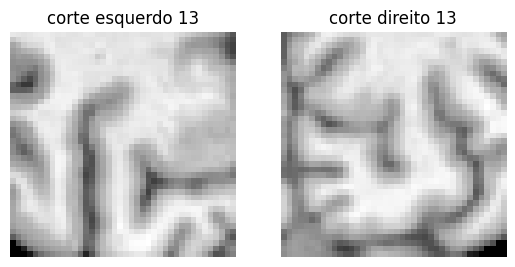

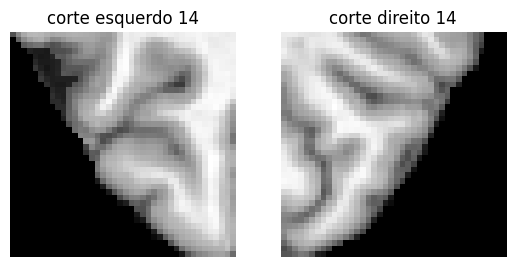

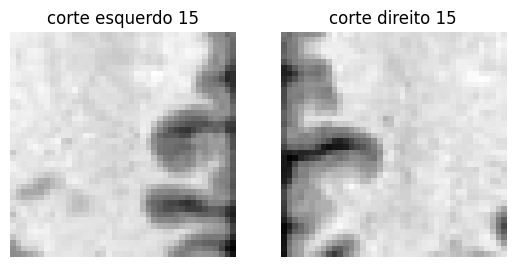

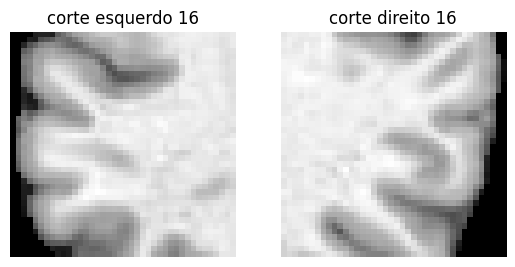

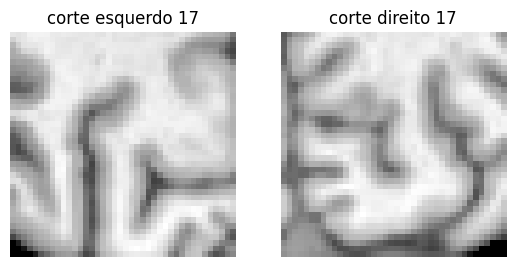

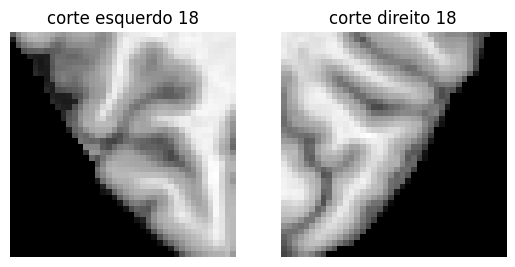

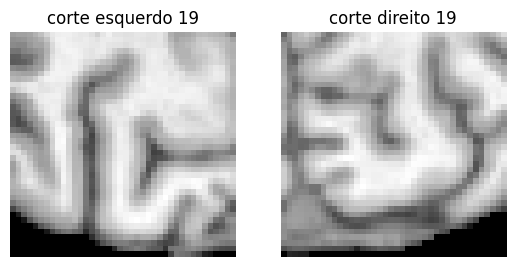

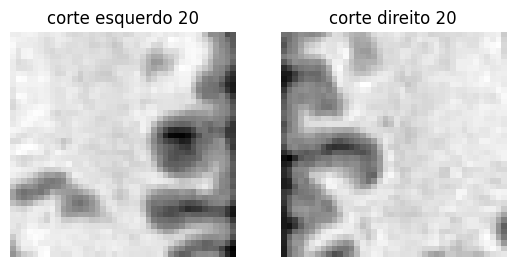

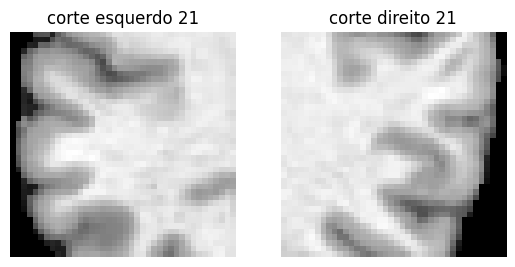

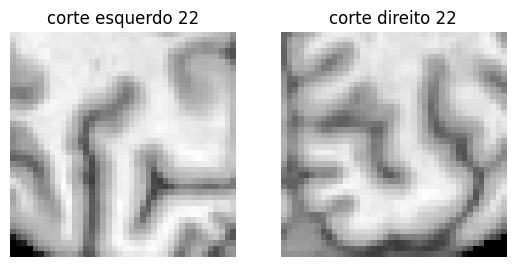

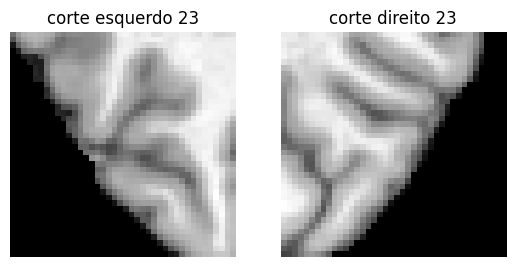

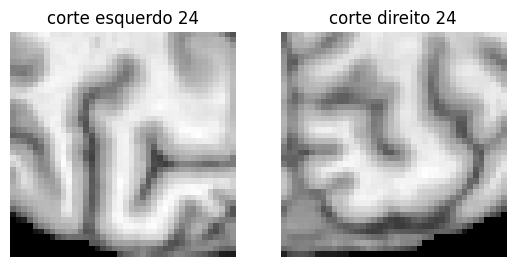

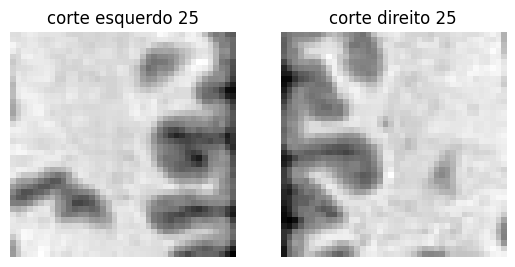

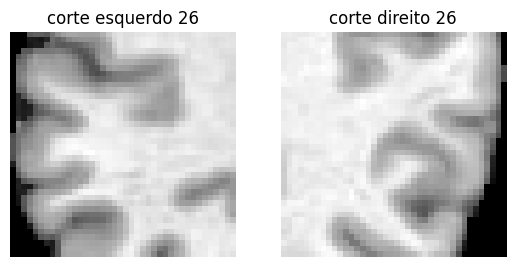

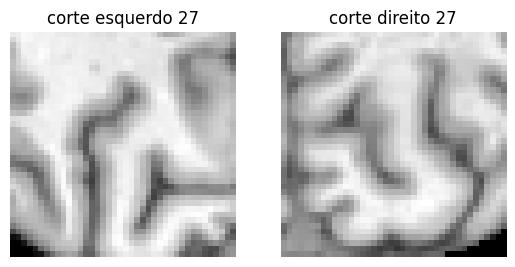

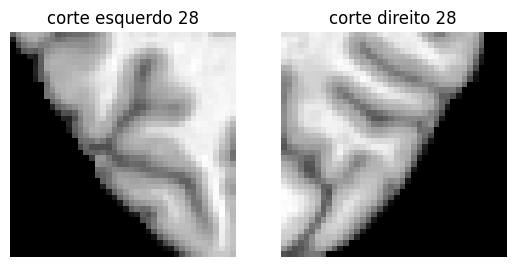

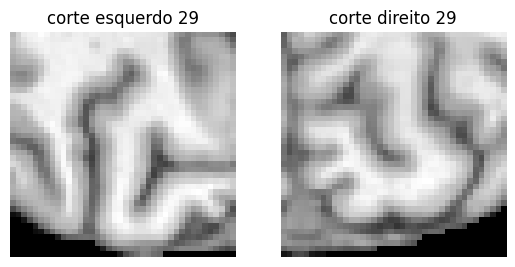

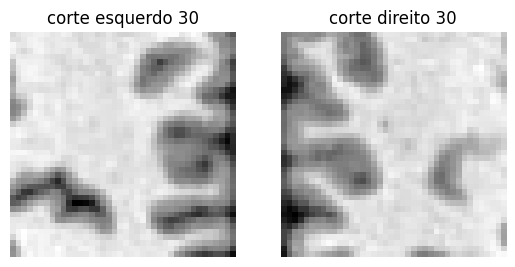

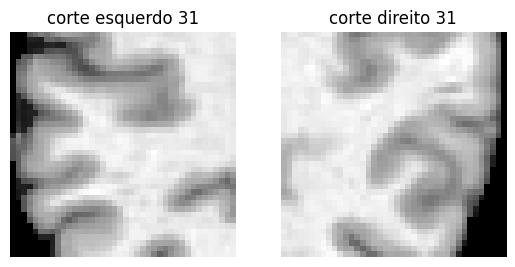

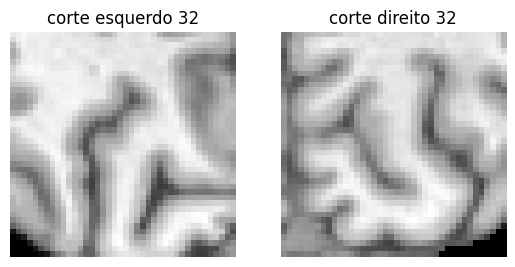

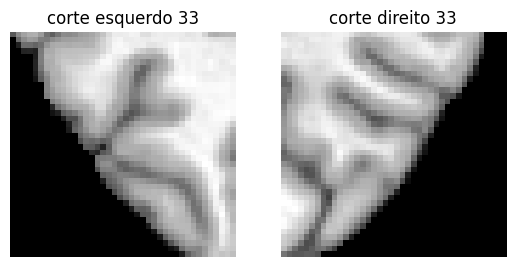

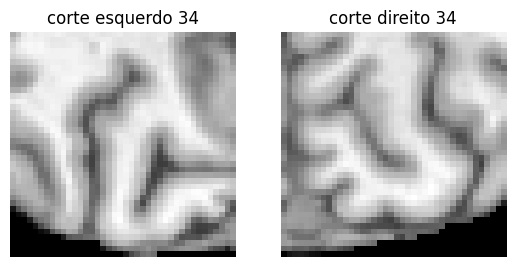

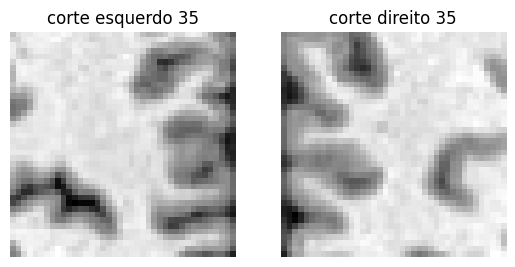

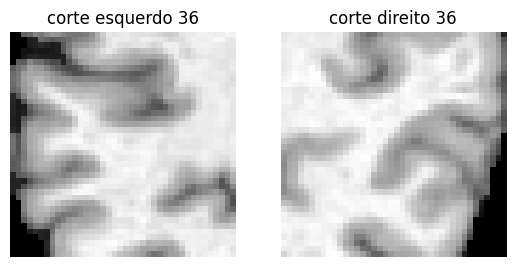

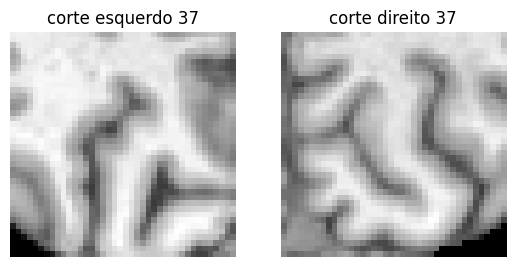

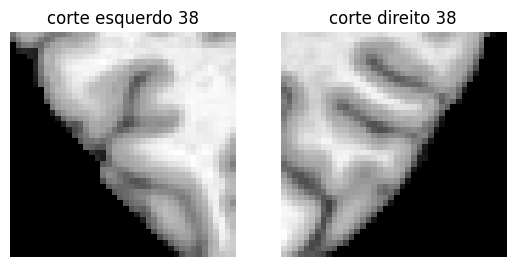

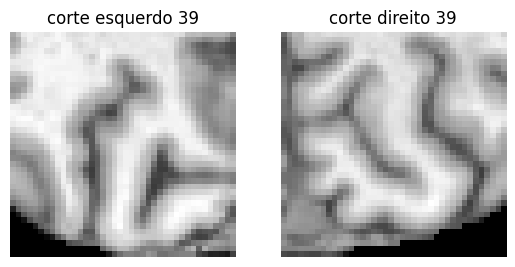

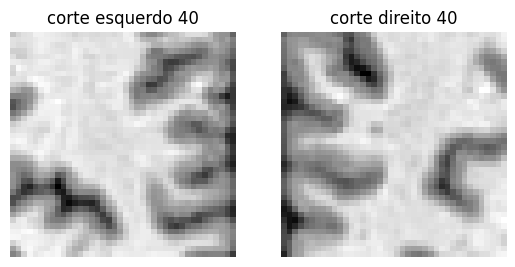

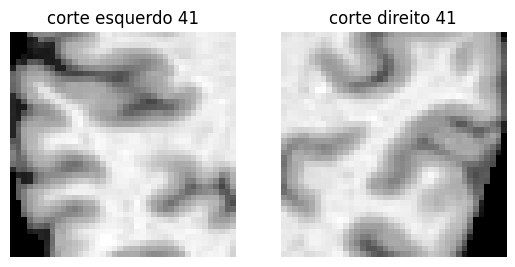

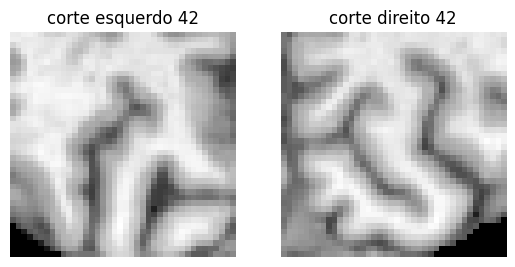

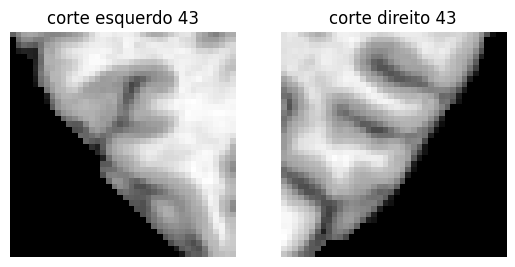

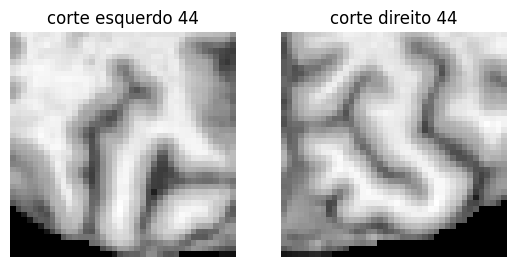

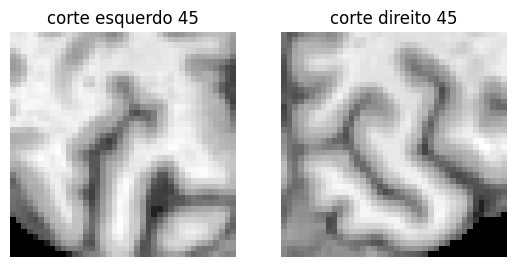

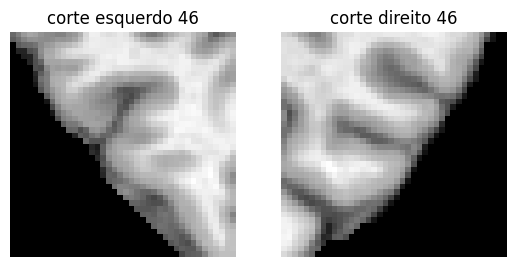

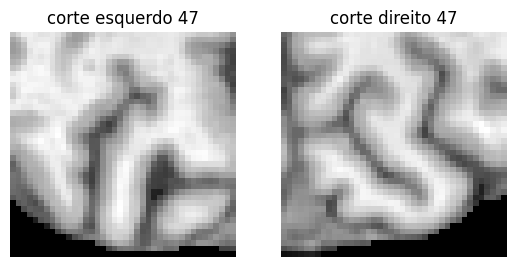

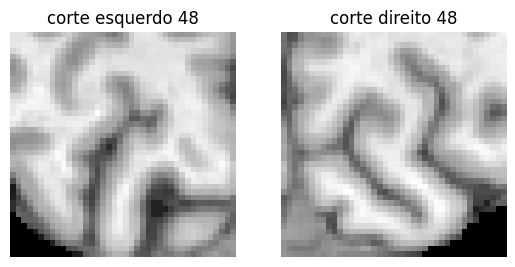

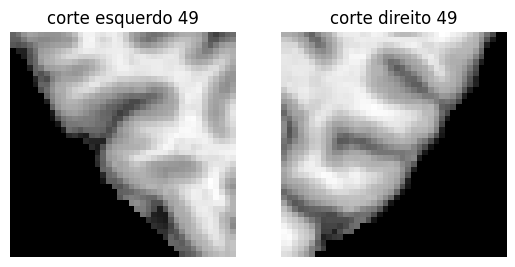

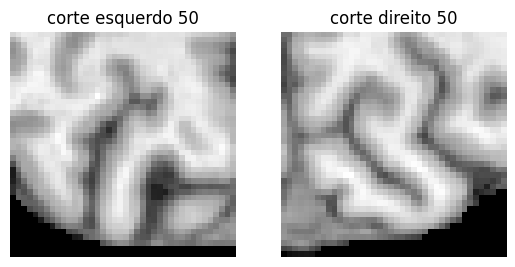

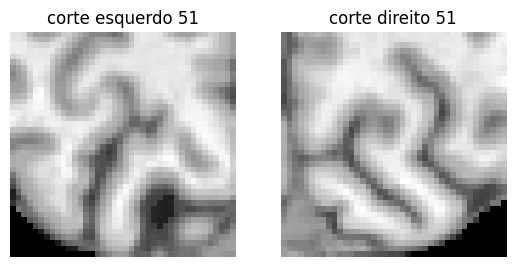

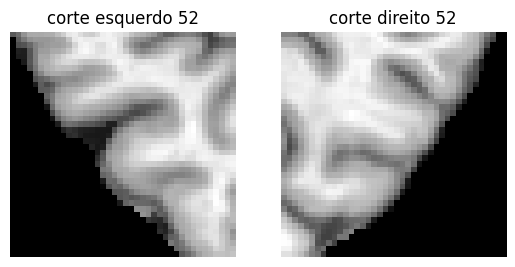

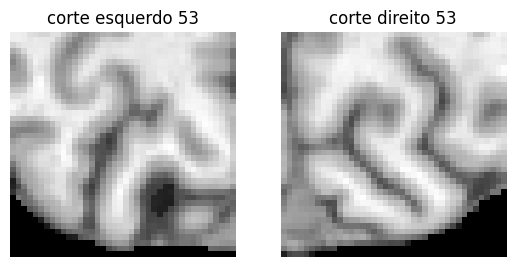

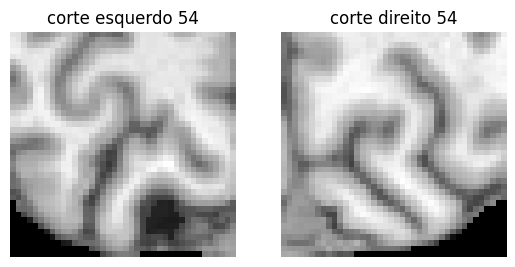

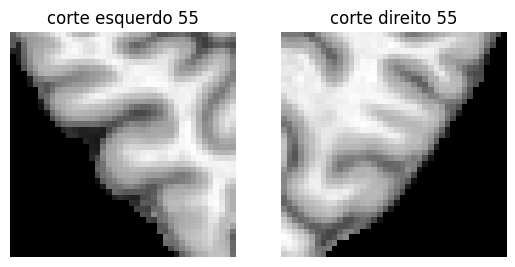

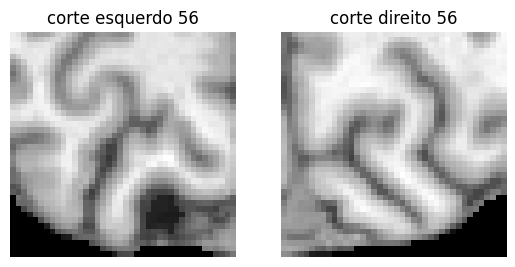

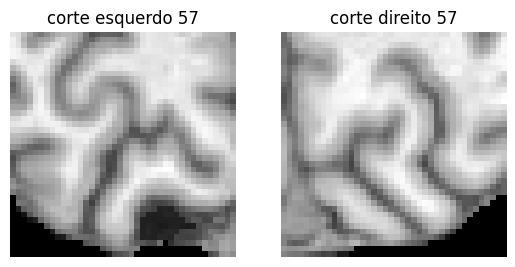

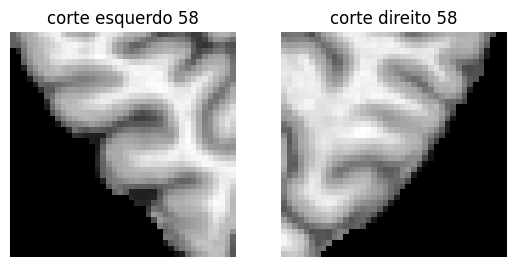

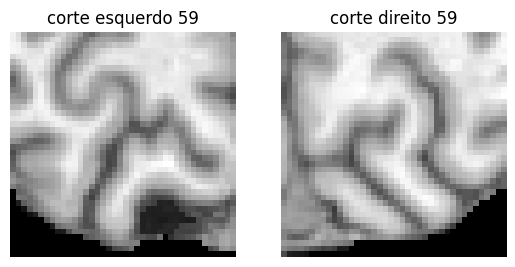

AttributeError: 'list' object has no attribute 'ndim'

In [21]:
for i in range(0, len(train_left_balanced['sub-00H10'])):
    if train_left_balanced['sub-00H10'][i].ndim == 2:
        plt.subplot(1, 2, 1)
        plt.imshow(train_left_balanced['sub-00H10'][i], cmap='gray')
        plt.axis('off')
        plt.title(f'corte esquerdo {i}')

        plt.subplot(1, 2, 2)
        plt.imshow(train_right_balanced['sub-00H10'][i], cmap='gray')
        plt.axis('off')
        plt.title(f'corte direito {i}')
        plt.show()

In [46]:
import numpy as np
from skimage.metrics import mean_squared_error

def filter_unmatched_images(train_left, train_right, val_left, val_right, mse_threshold=1000):
    """
    Filtra imagens do conjunto de validação que não possuem correspondência próxima no conjunto de treino.
    
    Parâmetros:
    - train_left: Lista/Numpy array com imagens do lado esquerdo do treino
    - train_right: Lista/Numpy array com imagens do lado direito do treino
    - val_left: Lista/Numpy array com imagens do lado esquerdo da validação
    - val_right: Lista/Numpy array com imagens do lado direito da validação
    - mse_threshold: Valor limite do erro quadrático médio para considerar imagens como similares

    Retorna:
    - unmatched_images: Lista de imagens de validação sem correspondência no treino
    """
    unmatched_l, unmatched_r = [], []
    
    for vl, vr in zip(val_left, val_right):
        found_match = False
        
        for tl, tr in zip(train_left, train_right):
            mse_left = mean_squared_error(vl, tl)
            mse_right = mean_squared_error(vr, tr)
            
            if mse_left < mse_threshold and mse_right < mse_threshold:
                found_match = True
                break
        
        if not found_match:
            unmatched_l.append((vl))
            unmatched_l.append((vr))
    
    return unmatched_l, unmatched_r


In [71]:
print(np.max(train_right_balanced[0]))
print(train_right_balanced[0].shape)

0.6061782555150067
(40, 40, 1)


In [73]:
print(np.max(test_right[0]))
print(test_right[0].shape)

0.8405599503655748
(40, 40, 1)


In [75]:
# Calcular MSE para alguns pares
for i in range(0, len(train_left_balanced)):  # Teste com até 5 pares
    mse_value = mean_squared_error(test_left[i], train_left_balanced[i])
    print(f"MSE entre recorte {i}: {mse_value}")


MSE entre recorte 0: 0.10808755045409901
MSE entre recorte 1: 0.03382045928099583
MSE entre recorte 2: 0.1794605325863325
MSE entre recorte 3: 0.13358399097707385
MSE entre recorte 4: 0.11815833207096108
MSE entre recorte 5: 0.05801641574715868
MSE entre recorte 6: 0.1710336670277229
MSE entre recorte 7: 0.09842305399027489
MSE entre recorte 8: 0.060456179367971714
MSE entre recorte 9: 0.028998488657190003
MSE entre recorte 10: 0.12045235984055683
MSE entre recorte 11: 0.08249448029997547
MSE entre recorte 12: 0.0699158967487715
MSE entre recorte 13: 0.06687903801481306
MSE entre recorte 14: 0.044186244359649185
MSE entre recorte 15: 0.1462489239592076
MSE entre recorte 16: 0.0489637767061628
MSE entre recorte 17: 0.0345883274098345
MSE entre recorte 18: 0.05146748824841508
MSE entre recorte 19: 0.06584098727123036
MSE entre recorte 20: 0.09689649204621821
MSE entre recorte 21: 0.13820621628846516
MSE entre recorte 22: 0.05345741298822827
MSE entre recorte 23: 0.06142173099872506
MSE e

IndexError: index 1026 is out of bounds for axis 0 with size 1026